In [1]:
# 필요한 모듈 불러오기
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap

In [2]:
# 데이터 정보
data_schema = pd.read_csv('./TC_ELCTY_ATMBL_ELCTC_RECD_20230609095252_schema.csv', encoding='euc-kr')
data_schema

,영문 컬럼명,한글 컬럼명,컬럼 타입,컬럼 길이,NULL 여부
0,ELCTC_DTM,충전_일시,VARCHAR2,19.0,True
1,CHRSTN_ID,충전소_ID,VARCHAR2,20.0,True
2,CHRGR_ID,충전기_ID,VARCHAR2,20.0,True
3,CTPR_CD,시도_코드,VARCHAR,10.0,True
4,SIGNGU_CD,시군구_코드,VARCHAR,5.0,True
5,CTPR_NM,시도_명,VARCHAR2,50.0,True
6,SIGNGU_NM,시군구_명,VARCHAR2,50.0,True
7,CHRSTN_NM,충전소_명,VARCHAR2,50.0,True
8,LA,위도,NUMBER,1310.0,False
9,LO,경도,NUMBER,1310.0,False


In [3]:
# 충전기ID, 시작일시, 종료일시, 전력사용량만 활용한다
# 충전기ID 별로 데이터를 정리한다
# 충전 속도는 일정하다고 가정한다
# 충전을 1시 30분부터 2시 30분까지 했다면 충전량을 30:30으로 나눠서 1시 데이터에 누적, 2시데이터에 누적한다
# 데이터를 기록한 총 날수로 나눠서 각 충전기ID의 시간별 충전량 평균치를 구한다
# 이 값으로 클러스터링 한다

In [4]:
# 데이터 목록 가져오기
path = "./TC_ELCTY_ATMBL_ELCTC_RECD_20230609095252/"
file_list = os.listdir(path)

In [5]:
# 데이터 가져오기
data = []
for file_name in file_list:
    file_path = path + file_name
    data.append(pd.read_csv(file_path)[['충전기_ID', '시작_일시', '종료_일시', '전력_사용량']])

data = pd.concat(data, ignore_index=True)

In [6]:
# 가져온 데이터 확인
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11094788 entries, 0 to 11094787
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   충전기_ID  object
 1   시작_일시   object
 2   종료_일시   object
 3   전력_사용량  int64 
dtypes: int64(1), object(3)
memory usage: 338.6+ MB


In [7]:
# 첫 데이터로 데이터 형식 확인
data.head(1)

,충전기_ID,시작_일시,종료_일시,전력_사용량
0,KRPPKCP0002,2022-12-31 22:12:28,2023-01-01 00:00:00,140


In [8]:
# 날짜 데이터에서 시분초 데이터만 추출해서 추가
data['시작_시간'] = (data['시작_일시'].str[-8:-6] + data['시작_일시'].str[-5:-3] + data['시작_일시'].str[-2:])
data['종료_시간'] = (data['종료_일시'].str[-8:-6] + data['종료_일시'].str[-5:-3] + data['종료_일시'].str[-2:])

In [9]:
# 날짜 데이터 삭제
data = data.drop(['시작_일시', '종료_일시'], axis=1)

In [10]:
# 바꾼 데이터 확인
data.head(1)

,충전기_ID,전력_사용량,시작_시간,종료_시간
0,KRPPKCP0002,140,221228,000000


In [11]:
# 충전기 id를 사전순으로 정렬한 것
ids = sorted(data['충전기_ID'].unique())

In [12]:
# 충전량 데이터
# 가로축 충전소 ID, 세로축 시각
id_time_charge = {}
for i in ids:
    id_time_charge[i] = np.zeros(24)

In [13]:
# '030000'을 정수형으로 바꾸면 030000이 아니라 30000이 되므로 뒤에서 부터 인덱싱 한다
def get_h(t):
    return int(t[:-4])
def get_m(t):
    return int(t[-4:-2])
def get_s(t):
    return int(t[-2:])

In [14]:
# 문자열 시간 데이터에서 시, 분, 초를 정수형으로 반환하는 함수
def get_hms(t):
    # 시, 분, 초
    return get_h(t), get_m(t), get_s(t)

In [15]:
# 초단위 시간
def modulo_ds(ds):
    # 하루는 86400초이다
    # 24*60*60 = 86400
    return ds%86400

In [16]:
# 총시간을 계산
def cal_total_s(h,m,s):
    return modulo_ds(3600*h+60*m+s)

In [17]:
# 두개의 문자열 시간 데이터의 차이를 초 단위로 반환하는 함수
def cal_ds(s,e):
    # 시분초 구하기
    sh, sm, ss = get_hms(s)
    eh, em, es = get_hms(e)

    # 시분초 각각의 차이 계산
    dh = eh-sh
    dm = em-sm
    ds = es-ss

    return cal_total_s(dh,dm,ds)

In [19]:
# 각각의 충전기의 시간별 데이터 입력

for i in range(len(data)):
    d = data.iloc[i] # 1개의 데이터 가져오기 
    
    id = d['충전기_ID'] # ID
    s = d['시작_시간'] # start time
    e = d['종료_시간'] # end time
    c = d['전력_사용량'] # charge

    # 충전량이 0이면 이상치이므로 버린다
    if c == 0:
        continue

    # 문자열 시간데이터 정수형으로 바꾸기
    sh = get_h(s)
    eh = get_h(e)

    # 총 충전시간 구하기
    ds = cal_ds(s,e)

    # 충전시간이 0이하이면 이상치 이므로 버린다
    if ds <= 0:
        continue

    # 정각시간문자열
    # 정각시간을 문자열로 구하기 위해 정의
    o = '0000'

    # 각 시간대의 충전량을 구하기
    # 소수점 아래는 버린다
    
    # 시작 시간과 다음 정각과의 시간차를 구한 뒤
    # 충전 시간과의 비율을 구해 전력 사용량과 곱해
    # 시간대의 충전량을 구하기
    id_time_charge[id][sh] += cal_ds(s, str(sh+1)+o)*c//ds

    # 시작 시간, 종료 시간이 아니라면 1시간 내내 충전하므로
    # 시간차를 구하지 않고 3600으로 계산한다
    if sh > eh:
        eh+=24
    for j in range(sh+1, eh):
        id_time_charge[id][j%24] += 3600*c//ds

    # 끝 시간과 그 전 정각과의 시간차를 구한 뒤
    # 충전 시간과의 비율을 구해 전력 사용량과 곱해
    # 시간대의 충전량을 구하기
    id_time_charge[id][eh%24] += cal_ds(str(eh)+o, e)*c//ds

In [20]:
# 2023년 1월 1일부터 3월 31일 까지 데이터 이므로
# 하루당 데이터를 얻으려면 날수로 나눠야한다
# 1월 : 31일
# 2월 : 28일
# 3월 : 31일
# 총  : 90일 

for i in ids:
    id_time_charge[i] //= 90

# 데이터 기록 후 데이터프레임으로 변환
# 충전량 데이터
# 가로축 시각, 세로축 충전소 ID
id_time_charge_df = pd.DataFrame(id_time_charge).T

In [22]:
# 데이터 전처리 확인
id_time_charge_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
KRPPKCP0001,11578.0,4168.0,648.0,278.0,184.0,205.0,1509.0,3650.0,2945.0,2313.0,...,2797.0,2161.0,1157.0,1677.0,862.0,1597.0,1298.0,1070.0,442.0,2087.0
KRPPKCP0002,1895.0,8281.0,8749.0,2743.0,360.0,354.0,321.0,2083.0,2303.0,2067.0,...,2428.0,1985.0,1045.0,1265.0,1281.0,1354.0,937.0,1254.0,3821.0,4040.0
KRPPKCP0003,7256.0,14747.0,11079.0,2485.0,404.0,74.0,303.0,3149.0,3342.0,3030.0,...,2916.0,2306.0,1218.0,1241.0,1313.0,1265.0,1262.0,1640.0,1168.0,1357.0
KRPPKCP0004,8215.0,3309.0,4205.0,3046.0,435.0,130.0,298.0,2810.0,2045.0,1507.0,...,2520.0,1861.0,829.0,674.0,1337.0,977.0,1219.0,1115.0,3250.0,7426.0
KRPPKCP0005,10163.0,11039.0,6823.0,1895.0,179.0,25.0,100.0,3044.0,3313.0,2671.0,...,2823.0,2423.0,1133.0,663.0,1069.0,1125.0,1742.0,1593.0,654.0,2631.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KRPPKCP0955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KRPPKCP0956,901.0,1543.0,128.0,0.0,0.0,33.0,823.0,956.0,1071.0,806.0,...,1080.0,942.0,711.0,837.0,895.0,481.0,376.0,87.0,19.0,393.0
KRPPKCP0957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KRPPKCP0958,722.0,53.0,0.0,9.0,0.0,0.0,0.0,324.0,254.0,234.0,...,3.0,47.0,294.0,3.0,2.0,3.0,5.0,421.0,1326.0,3756.0


In [ ]:
# 전처리는 오래걸리기 때문에 
# 결과 데이터프레임을 파일로 저장
id_time_charge_df.to_csv('./pretreatment_data.csv')

# 이후 클러스터링은 여기 아래서부터 전처리한 파일로 하면 된다.

In [1]:
# 필요한 모듈 불러오기
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from matplotlib.colors import LinearSegmentedColormap

In [2]:
id_time_charge_df = pd.read_csv('./pretreatment_data.csv', index_col=0)
id_time_charge_df

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
KRPPKCP0001,11578.0,4168.0,648.0,278.0,184.0,205.0,1509.0,3650.0,2945.0,2313.0,...,2797.0,2161.0,1157.0,1677.0,862.0,1597.0,1298.0,1070.0,442.0,2087.0
KRPPKCP0002,1895.0,8281.0,8749.0,2743.0,360.0,354.0,321.0,2083.0,2303.0,2067.0,...,2428.0,1985.0,1045.0,1265.0,1281.0,1354.0,937.0,1254.0,3821.0,4040.0
KRPPKCP0003,7256.0,14747.0,11079.0,2485.0,404.0,74.0,303.0,3149.0,3342.0,3030.0,...,2916.0,2306.0,1218.0,1241.0,1313.0,1265.0,1262.0,1640.0,1168.0,1357.0
KRPPKCP0004,8215.0,3309.0,4205.0,3046.0,435.0,130.0,298.0,2810.0,2045.0,1507.0,...,2520.0,1861.0,829.0,674.0,1337.0,977.0,1219.0,1115.0,3250.0,7426.0
KRPPKCP0005,10163.0,11039.0,6823.0,1895.0,179.0,25.0,100.0,3044.0,3313.0,2671.0,...,2823.0,2423.0,1133.0,663.0,1069.0,1125.0,1742.0,1593.0,654.0,2631.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
KRPPKCP0955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KRPPKCP0956,901.0,1543.0,128.0,0.0,0.0,33.0,823.0,956.0,1071.0,806.0,...,1080.0,942.0,711.0,837.0,895.0,481.0,376.0,87.0,19.0,393.0
KRPPKCP0957,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
KRPPKCP0958,722.0,53.0,0.0,9.0,0.0,0.0,0.0,324.0,254.0,234.0,...,3.0,47.0,294.0,3.0,2.0,3.0,5.0,421.0,1326.0,3756.0


In [3]:
# K-Means 클러스터링
n_clusters = 3  # 클러스터 개수 설정
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
kmeans.fit(id_time_charge_df)

# 클러스터링 결과
labels = kmeans.labels_

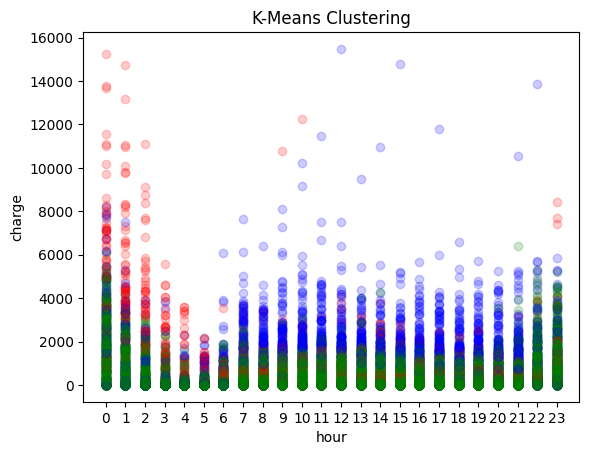

In [4]:
# 클러스터링 결과 시각화
colors = ['g', 'b', 'r']

for i in range(len(id_time_charge_df)):
    plt.scatter(id_time_charge_df.columns, id_time_charge_df.iloc[i], c=colors[labels[i]], alpha=0.2)
plt.title('K-Means Clustering')
plt.xlabel('hour')
plt.ylabel('charge')
plt.show()

In [5]:
# 점들이 겹쳐서 결과가 잘 안 보인다
# 각 색을 따로 그려보자

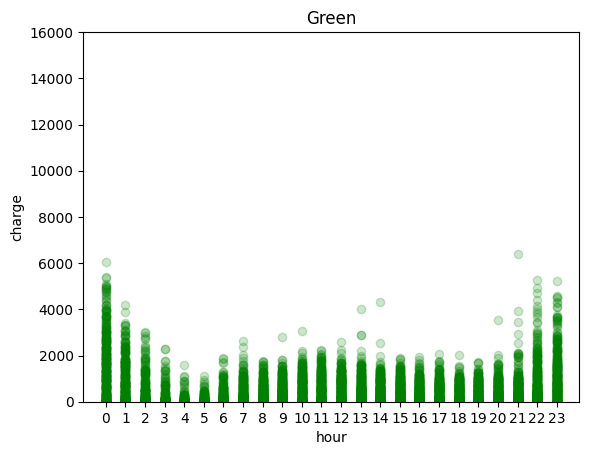

In [6]:
# 초록색 분류
plt.ylim(0,16000)
for i in range(len(id_time_charge_df)):
    if labels[i] != 0:
        continue
    plt.scatter(id_time_charge_df.columns, id_time_charge_df.iloc[i], c=colors[labels[i]], alpha=0.2)
plt.title('Green')
plt.xlabel('hour')
plt.ylabel('charge')
plt.show()

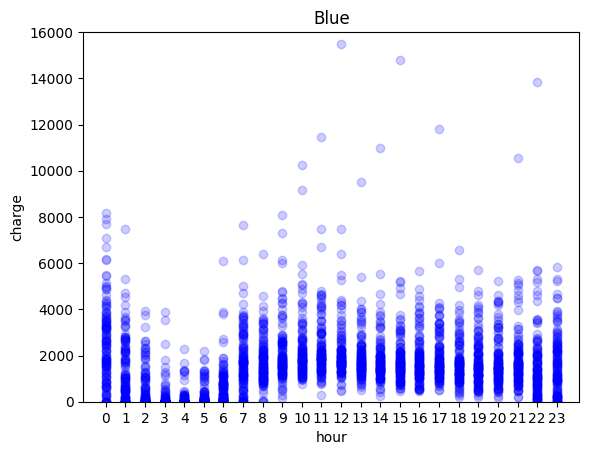

In [7]:
# 파란색
plt.ylim(0,16000)
for i in range(len(id_time_charge_df)):
    if labels[i] != 1:
        continue
    plt.scatter(id_time_charge_df.columns, id_time_charge_df.iloc[i], c=colors[labels[i]], alpha=0.2)
plt.title('Blue')
plt.xlabel('hour')
plt.ylabel('charge')
plt.show()

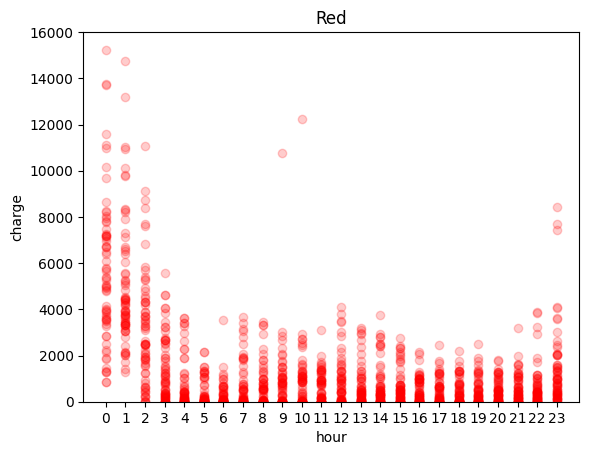

In [8]:
# 빨간색
plt.ylim(0,16000)
for i in range(len(id_time_charge_df)):
    if labels[i] != 2:
        continue
    plt.scatter(id_time_charge_df.columns, id_time_charge_df.iloc[i], c=colors[labels[i]], alpha=0.2)
plt.title('Red')
plt.xlabel('hour')
plt.ylabel('charge')
plt.show()

In [9]:
# 시간에 따른 분포가 보인다.
# 더 잘 알기 위해 각 색의 평균 시각화한다.

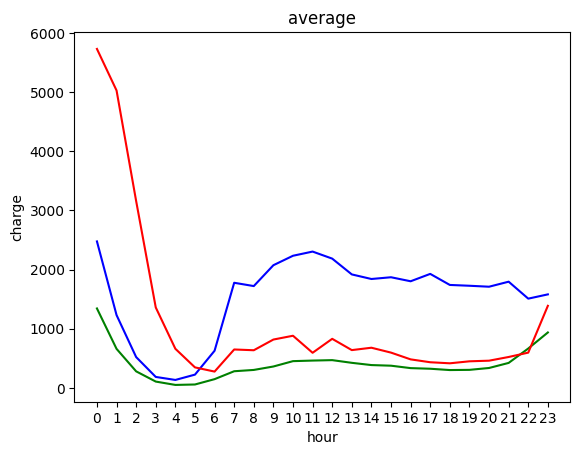

In [10]:
# 각 색의 평균 시각화

# 각 색의 개수
g, b, r = np.sum(labels == 0), np.sum(labels == 1), np.sum(labels == 2)

# 평균값을 계산할 빈 배열 생성
green = [0 for i in range(24)]
blue = [0 for i in range(24)]
red = [0 for i in range(24)]

for i in range(len(id_time_charge_df)):
    # 초록색 합
    if labels[i] == 0:
        green += id_time_charge_df.iloc[i]
    # 파란색 합
    elif labels[i] == 1:
        blue += id_time_charge_df.iloc[i]
    # 빨간색 합
    elif labels[i] == 2:
        red += id_time_charge_df.iloc[i]
# 평균      
green /= g
blue /= b
red /= r

# 꺾은선 그래프
plt.plot(id_time_charge_df.columns, green, c='g')
plt.plot(id_time_charge_df.columns, blue, c='b')
plt.plot(id_time_charge_df.columns, red, c='r')
plt.title('average')
plt.xlabel('hour')
plt.ylabel('charge')
plt.show()

In [11]:
# 결과가 잘 보이도록 차원축소를 한다

In [23]:
# 커스텀 cmap. 같은 색을 내는 cmap이 없어서 만들었다.
colors = ['#00FF00', '#0000FF', '#FF0000']
custom_cmap = LinearSegmentedColormap.from_list('my_cmap', colors)

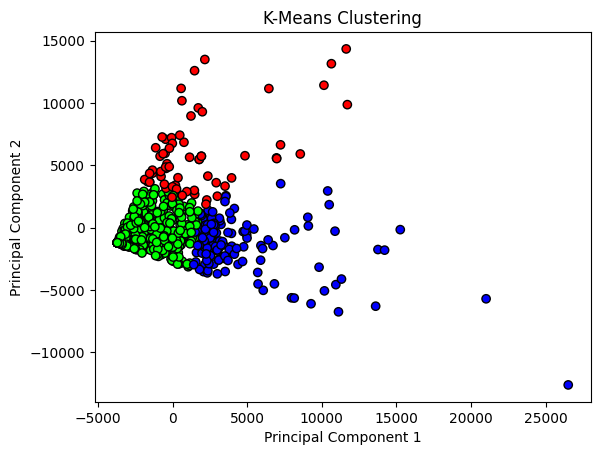

In [24]:
# 2차원으로 시각화하기 위해 PCA를 사용하여 2차원으로 축소
pca = PCA(n_components=2)
id_time_charge_df_pca = pca.fit_transform(id_time_charge_df)

# 클러스터링 결과 시각화
plt.scatter(id_time_charge_df_pca[:, 0], id_time_charge_df_pca[:, 1], c=labels, cmap=custom_cmap, edgecolor='k') # , cmap='Spectral'
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [13]:
# 잘 구분되는 것을 알 수 있다

### 결론
1. 충전기를 3가지로 구분했을 때 꽤 명확한 특징이 나타난다.
    - 시간대와 상관없이 사용량이 적은 것
    - 새벽을 제외한 시간대에 사용량이 많은 것
    - 밤 시간대에만 사용량이 많은 것
2. 시간대와 상관없이 사용량이 적은 것과 낮 시간대에 사용량이 많은 것은 공용과 업무용의 합집합에서 접근성이 안 좋은 것과 좋은 것의 구분이라고 추측한다.
3. 밤 시간대에 사용량이 많은 것은 아파트용으로 추측한다.
4. 위 조사에서는 1시간 단위로 사용량을 분석했는데 더 작은 시간단위로 분석하면 더 많은 갈래로 구분할 수 있을 것이다. 